In [112]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from data import RealMatrix
from cvx_nuc_norm import reg_mse_solver

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", device)

Device : cpu


In [114]:
class Args:
    reg = 0.01
    N = 20
    n = 7
    r = 2
    min_val = -1.0
    max_val = 1.0
    min_vocab = -1.0
    max_vocab = 1.0
    prec = 2

args = Args()

generator = RealMatrix(args, device=device)

mask_list = [0.1, 0.3, 0.5, 0.7, 0.9]
tau_list = np.linspace(0, 1, 11)
seed_list = [0, 1, 2, 3, 4]

L_mean, L_std = {}, {}
Lobs_mean, Lobs_std = {}, {}
Lmask_mean, Lmask_std = {}, {}

for p_mask in mask_list:
    # Seeds results
    L_all_seeds = []
    Lobs_all_seeds = []
    Lmask_all_seeds = []

    for seed in seed_list:
        torch.manual_seed(seed)
        np.random.seed(seed)

        L_list, Lobs_list, Lmask_list = [], [], []

        for tau in tau_list:
            _, A, mask = generator.sample(
                n_samples=args.N,
                m=args.n,
                n=args.n,
                r=args.r,
                p_mask=p_mask,
                tau=tau,
                return_uv=False
            )

            A = A.cpu()
            mask = mask.cpu().float()
            sol_reg_mse = torch.zeros_like(A)

            # Solve with convex method
            for i in range(A.shape[0]):
                sol_reg_mse[i] = torch.from_numpy(
                    reg_mse_solver(
                        A=A[i].numpy(),
                        mask=mask[i].numpy(),
                        size=torch.sum(mask[i]).item(),
                        reg=args.reg
                    )
                )

            # MSE
            lobs = F.mse_loss(sol_reg_mse[mask == 1], A[mask == 1]).item()
            lmask = F.mse_loss(sol_reg_mse[mask == 0], A[mask == 0]).item()
            ltotal = F.mse_loss(sol_reg_mse, A).item()

            L_list.append(ltotal)
            Lobs_list.append(lobs)
            Lmask_list.append(lmask)

        # Seeds
        L_all_seeds.append(L_list)
        Lobs_all_seeds.append(Lobs_list)
        Lmask_all_seeds.append(Lmask_list)

    
    key = str(round(p_mask, 2))
    L_mean[key] = np.mean(L_all_seeds, axis=0)
    L_std[key] = np.std(L_all_seeds, axis=0)
    Lobs_mean[key] = np.mean(Lobs_all_seeds, axis=0)
    Lobs_std[key] = np.std(Lobs_all_seeds, axis=0)
    Lmask_mean[key] = np.mean(Lmask_all_seeds, axis=0)
    Lmask_std[key] = np.std(Lmask_all_seeds, axis=0)

    print(f"\n=== p_mask = {p_mask} ===")
    print(f"{'τ':>5} | {'L_mean':>10} ± {'std':>7} | {'L_obs':>10} ± {'std':>7} | {'L_mask':>10} ± {'std':>7}")
    print("-" * 70)
    for i, tau in enumerate(tau_list):
        print(f"{tau:>5.2f} | {L_mean[key][i]:>10.4f} ± {L_std[key][i]:>7.4f} | "
              f"{Lobs_mean[key][i]:>10.4f} ± {Lobs_std[key][i]:>7.4f} | "
              f"{Lmask_mean[key][i]:>10.4f} ± {Lmask_std[key][i]:>7.4f}")



=== p_mask = 0.1 ===
    τ |     L_mean ±     std |      L_obs ±     std |     L_mask ±     std
----------------------------------------------------------------------
 0.00 |     0.0035 ±  0.0005 |     0.0026 ±  0.0001 |     0.0143 ±  0.0050
 0.10 |     0.0036 ±  0.0006 |     0.0026 ±  0.0001 |     0.0155 ±  0.0067
 0.20 |     0.0040 ±  0.0007 |     0.0026 ±  0.0001 |     0.0199 ±  0.0081
 0.30 |     0.0037 ±  0.0003 |     0.0026 ±  0.0001 |     0.0159 ±  0.0037
 0.40 |     0.0034 ±  0.0003 |     0.0026 ±  0.0001 |     0.0122 ±  0.0026
 0.50 |     0.0035 ±  0.0003 |     0.0026 ±  0.0000 |     0.0142 ±  0.0036
 0.60 |     0.0037 ±  0.0004 |     0.0026 ±  0.0001 |     0.0166 ±  0.0044
 0.70 |     0.0039 ±  0.0005 |     0.0026 ±  0.0000 |     0.0182 ±  0.0053
 0.80 |     0.0039 ±  0.0006 |     0.0026 ±  0.0000 |     0.0192 ±  0.0071
 0.90 |     0.0042 ±  0.0013 |     0.0026 ±  0.0001 |     0.0230 ±  0.0157
 1.00 |     0.0049 ±  0.0010 |     0.0026 ±  0.0001 |     0.0303 ±  0.0112

=== p_

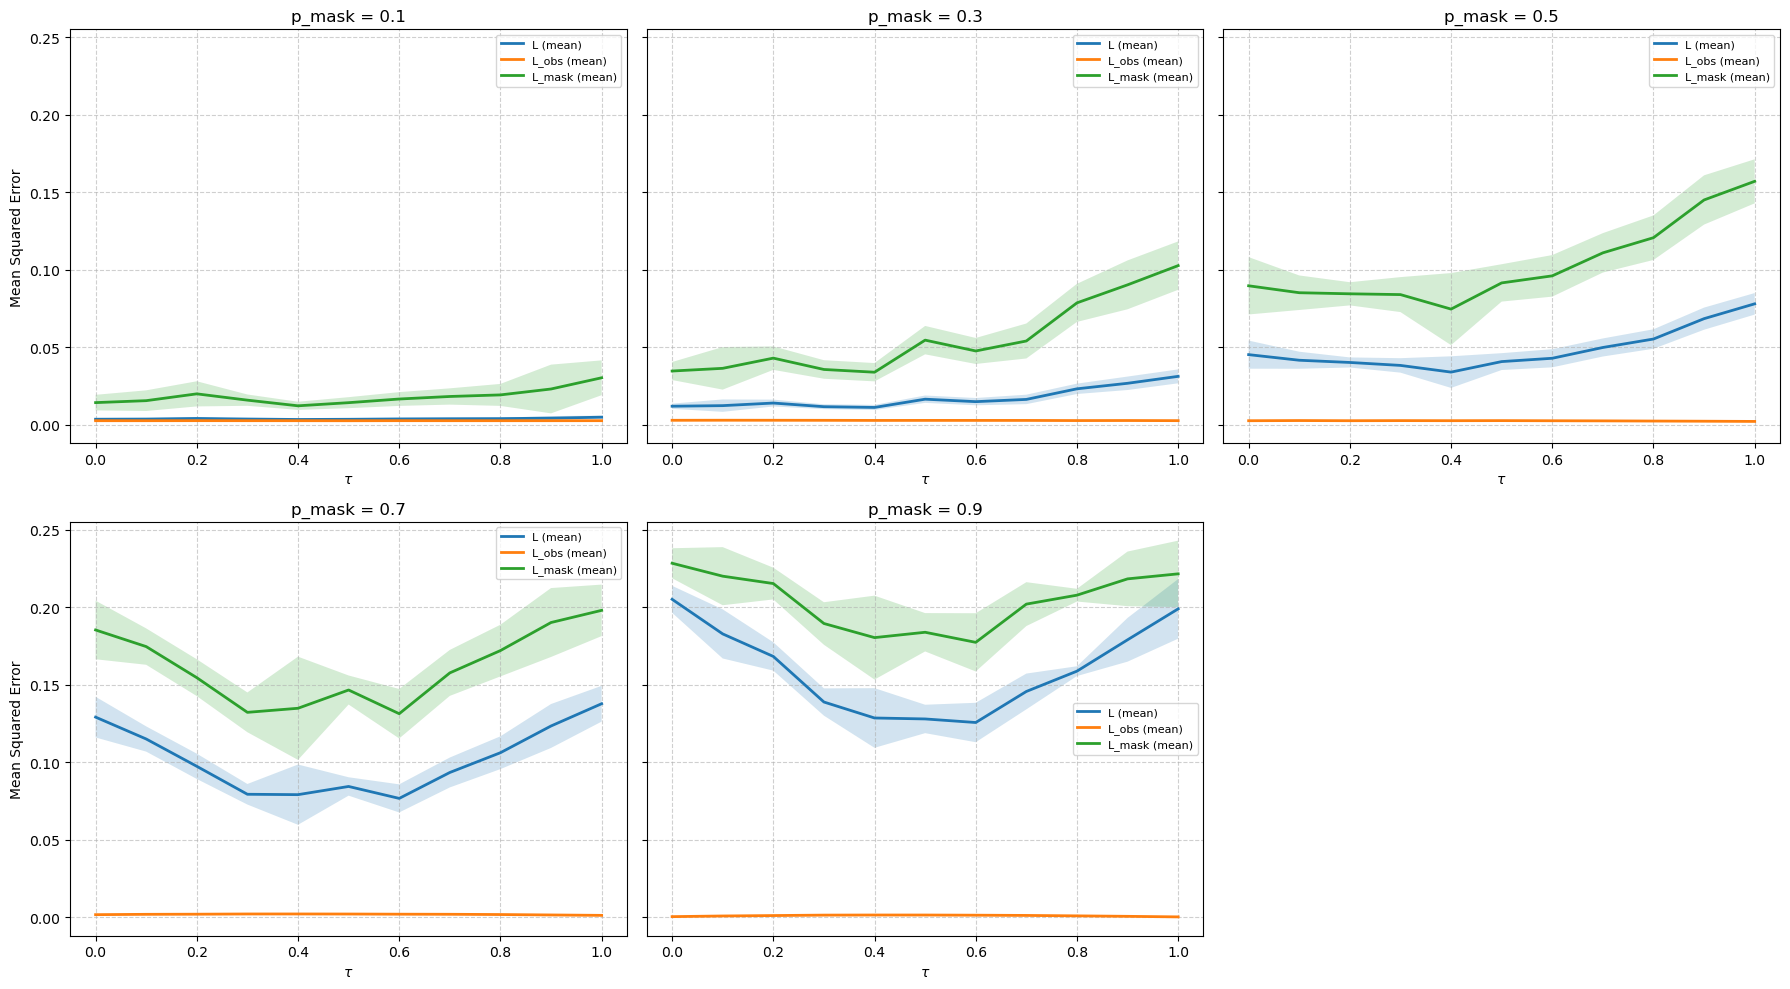

In [115]:
L_mean = {str(k): v for k, v in L_mean.items()}
L_std = {str(k): v for k, v in L_std.items()}
Lobs_mean = {str(k): v for k, v in Lobs_mean.items()}
Lobs_std = {str(k): v for k, v in Lobs_std.items()}
Lmask_mean = {str(k): v for k, v in Lmask_mean.items()}
Lmask_std = {str(k): v for k, v in Lmask_std.items()}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for i, p_mask in enumerate(mask_list):
    key = str(p_mask)
    ax = axes[i]

    # L_mean
    ax.plot(tau_list, L_mean[key], label='L (mean)', linewidth=2)
    ax.fill_between(tau_list,
                    L_mean[key] - L_std[key],
                    L_mean[key] + L_std[key],
                    alpha=0.2)

    # L_obs_mean
    ax.plot(tau_list, Lobs_mean[key], label='L_obs (mean)', linewidth=2)
    ax.fill_between(tau_list,
                    Lobs_mean[key] - Lobs_std[key],
                    Lobs_mean[key] + Lobs_std[key],
                    alpha=0.2)

    # L_mask_mean
    ax.plot(tau_list, Lmask_mean[key], label='L_mask (mean)', linewidth=2)
    ax.fill_between(tau_list,
                    Lmask_mean[key] - Lmask_std[key],
                    Lmask_mean[key] + Lmask_std[key],
                    alpha=0.2)

    ax.set_title(f"p_mask = {p_mask}")
    ax.set_xlabel(r"$\tau$")
    ax.grid(True, linestyle='--', alpha=0.6)
    if i % 3 == 0:
        ax.set_ylabel("Mean Squared Error")
    ax.legend(fontsize=8)

# Supprimer le subplot vide
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()
